# DSCI 100 - Group Project Final Report

**Group 008-1: Jason Kim, Sam Lui, Jarod Paulson, & Sen Wang**

## Introduction

The Pacific Laboratory for Artificial Intelligence (PLAI), a research group  at UBC, is recruiting individuals to participate in an AI research project called PLAICraft, a Minecraft-based data collection platform. PLAI wants to know the “kinds” of players most likely to contribute a large amount of data in order to orient their recruiting efforts towards these players. To inform their efforts, we aim to answer the question: can we accurately predict future players’ playtime based on age and experience level using the PLAICraft data? In this report, we perform an exploratory analysis of the data and build a predictive model to determine whether certain age and experience profiles exist that could be expected to contribute large amounts of data, and help inform PLAI’s recruiting strategies.

PLAI provided two datasets: one containing 196 records of individual players and 9 variables (**Table 1**), and another containing records of 1535 logged play sessions and 5 variables (**Table 2**).

**Table 1. Players Dataset Summary**
| Variable | Type (General; Data Type in R) | Meaning |
|:--------:|:--------:|:--------:|
| experience | categorical, ordinal; character | a player’s self-reported experience with Minecraft |
| subscribe | categorical, nominal; logical | whether a player has subscribed to PLAICraft’s email updates |
| hashedEmail | categorical, nominal; character |  an encoded user email |
| played_hours | quantitative, continuous; double | the total number of hours played by a given player |
| name | categorical, nominal; character | pseudonym selected by player to use while playing |
| gender | categorical, nominal; character | a player’s self-reported gender |
| age | quantitative, discrete; double | a player’s self-reported age |
| individualId | NA | unclear variable type and meaning because no values exist | 
| organizationName | NA | unclear variable type and meaning because no values exist | 

**Table 2. Sessions Dataset Summary** 
| Variable | Type (General; Data Type in R)| Meaning |
|:--------:|:--------:|:--------:|
| hashedEmail | categorical, nominal; character |  an encoded user email |
| start_time | quantitative, continuous; double | the actual start time of a Minecraft play session |
| end_time | quantitative, continuous; double | the actual end time of a play session |
| original_start_time | quantitative, continuous; double | the “scheduled” start time of a session in UNIX timestamp format  which is the number of seconds since January 1, 1970 (UTC) |
| original_end_time | quantitative, continuous; double | the “scheduled” end time of a session in UNIX format |

## Methods and Results

Considering our research question, the played hours variable was an appropriate response variable for our planned predictive model. Age and experience were selected as predictor variables given their ostensible relationship with a player’s total playtime. We also considered gender, however, aside from determining that male participants made up the highest player counts, nothing significant was noted.

We chose not to use sessions.csv for several reasons. 
1. There was significant complexity in calculating each individual session duration, as it required accounting for date changes if playtime was spread across two days. We were advised to calculate session playtimes using (original_end_time - original_start_time). However, this yielded nonsensical values (either 0s, ~2778 hours, or ~5556 hours) and discrepancies with the session playtimes computed using start_time and end_time.
2. The dataset did not contain variables related to player characteristics that would be important for our research question.

### Wrangling Methodology

First, we loaded the proper libraries required to perform the data analysis and read the data from their respective URLs.

As mentioned, we found the data from sessions.csv to be unconducive towards our analysis. Therefore, we used players.csv and selected the relevant variables age, experience, and total played hours. 


In [1]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
#loading the libraries needed for data wrangling, predictive work and visualizations

players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

players_data <- read_csv(players_url)

sample_players_data <- players_data |>
head()
sample_players_data

sessions_data <- read_csv(sessions_url)

sample_players_data <- sessions_data |>
head()
sample_players_data

#Reading in raw dataset (not yet manipulated), displaying first few rows of respective datasets

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [2]:
cleaned_players <- players_data |>
select(experience, played_hours, name, age, gender)

sample_cleaned <- cleaned_players |>
head()

sample_cleaned
#Filtered data in accordance with variables to be explored, ignored individualID and organizationName as both variables contained all NULL values, displays first few rows of respective tibble

experience,played_hours,name,age,gender
<chr>,<dbl>,<chr>,<dbl>,<chr>
Pro,30.3,Morgan,9,Male
Veteran,3.8,Christian,17,Male
Veteran,0.0,Blake,17,Male
Amateur,0.7,Flora,21,Female
Regular,0.1,Kylie,21,Male
Amateur,0.0,Adrian,17,Female


experience,total_played_hours
<fct>,<dbl>
Veteran,0.6479167
Pro,2.6000000
Regular,18.2083333
Amateur,6.0174603
Beginner,1.2485714


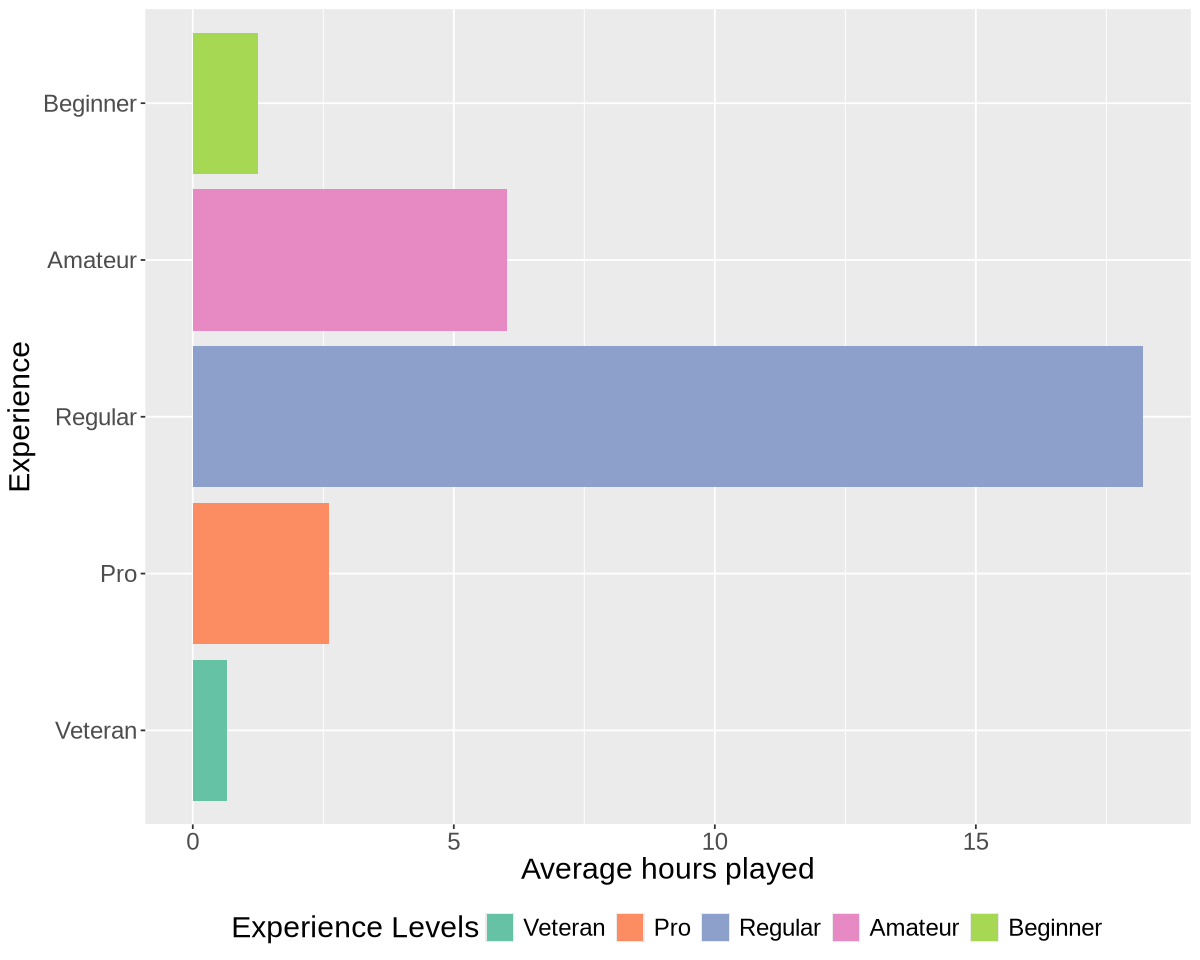

In [3]:
exp_total_hours <- cleaned_players |>
select(experience, played_hours) |>
mutate(experience = factor(experience, levels = c("Veteran", "Pro", "Regular", "Amateur", "Beginner"))) |>
group_by(experience) |>
summarize(total_played_hours = mean(played_hours))
exp_total_hours
#Created a tibble that calculates the average played hours, based on Experience classification

options(repr.plot.width = 10, repr.plot.height = 8)
exp_hours_plot <- exp_total_hours |>
ggplot(aes(x = total_played_hours, y = experience, fill = experience)) + 
geom_bar(stat = "identity") +
labs(x = "Average hours played", 
     y = "Experience", 
     fill = "Experience Levels") +
scale_fill_brewer(palette = "Set2") +
theme(text = element_text(size = 18),
     legend.position = "bottom")
exp_hours_plot

**Figure 1. Experience vs Average Hours Played**

We assessed the average number of PLAICraft hours played, grouped by experience. **Figure 1** shows that “Regular” players played the most hours on average (18.2 hours), followed by “Amateur” players (6.0 hours). Surprisingly, “Pro” and “Veteran” players played the least (2.6 and 0.6 hours, respectively). This was unexpected, since we expected that high-ranking players would play more. However, experience is a self-reported field at the start of game registration and therefore we cannot verify the validity of this variable. For instance, without any standardized criteria, it is possible players may have under-/over-reported their own experience levels.

age,played_hours,experience
<dbl>,<dbl>,<chr>
17,223.1,Regular
20,218.1,Regular
19,178.2,Regular
16,150.0,Amateur
23,56.1,Amateur
17,53.9,Amateur


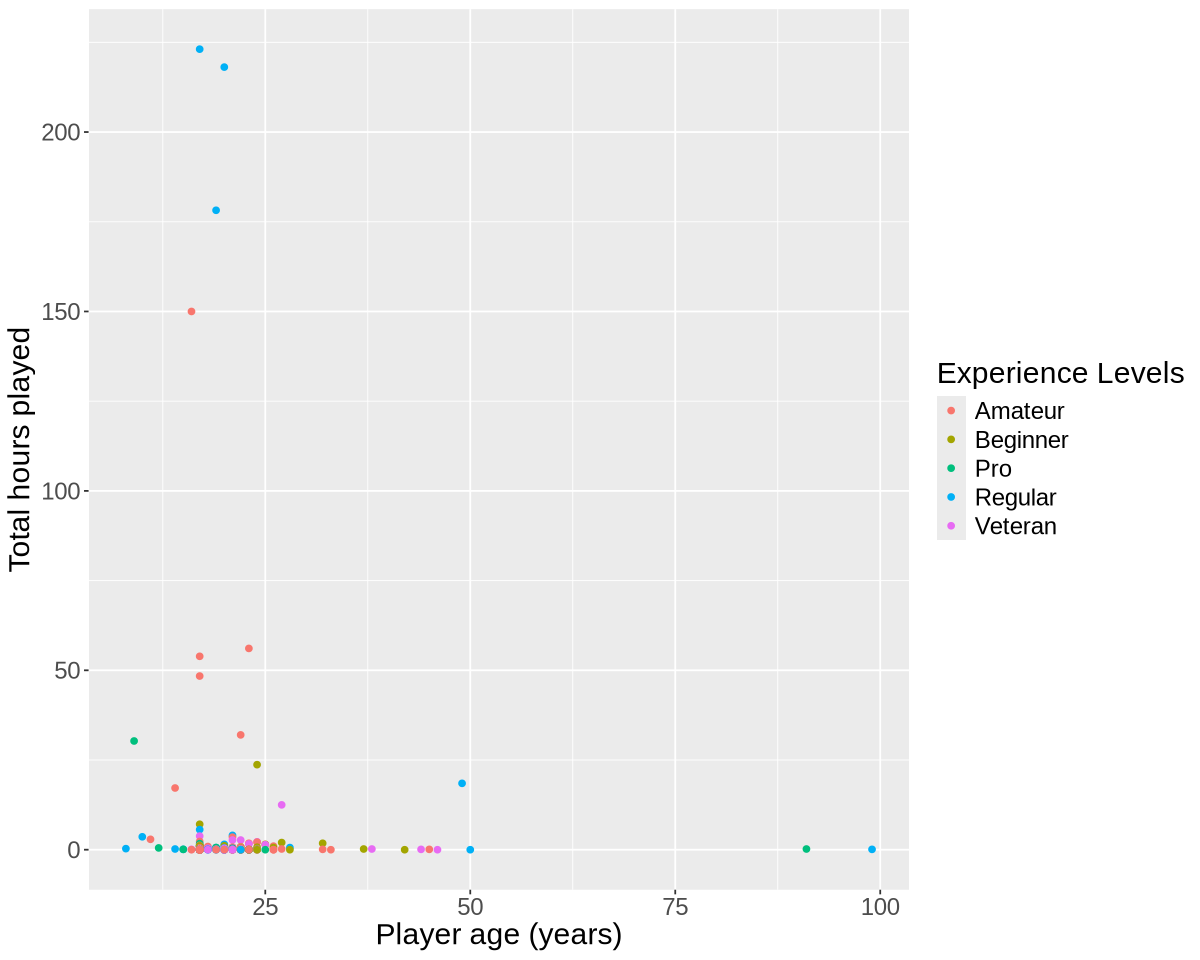

In [4]:
hours_per_age <- cleaned_players |>
select(age, played_hours, experience) |>
arrange(by = desc(played_hours))

sample_hpa <- hours_per_age |>
head()
sample_hpa
#Produced a sample tibble of of age and played_hours from cleaned_players, all records of each player noted here

options(repr.plot.width = 10, repr.plot.height = 8)
new_age_plot <- hours_per_age |>
ggplot(aes(x = age, y = played_hours, color = experience)) +
geom_point() + 
labs(x = "Player age (years)", 
     y = "Total hours played", 
    color = "Experience Levels") +
scale_y_continuous() + 
theme(text = element_text(size = 18))
new_age_plot
#Plotted the played hours for EACH player -> Each "dot" corresponds to the players' individual age, separated by their Experience

**Figure 2: Total Individual Hours Played vs Age**

We also examined the relationship between age and total played hours for each registered player, color-coded by experience. **Figure 2** shows that the age of current players ranged from 8 to 99 years.  Age outliers (i.e., > 90 years) could be attributed to self-reporting errors during registration. Due to the possibility of outliers affecting our analysis, they should be removed in further downstream analysis. 

In [5]:
highest_play_ages <- cleaned_players |>
group_by(age) |>
summarize(average_played_hours = mean(played_hours)) |>
arrange(by=desc(average_played_hours)) |>
slice(1:5)
#Produces a tibble that displays the top 5 player-reported ages that have the highest hours played

highest_play_ages
#Verifies finding through scatterplot: 16 y.o.'s play the most hours

age,average_played_hours
<dbl>,<dbl>
16,50.03333
9,30.30000
19,25.65714
49,18.50000
20,15.82857


Through further exploration, we calculated the average played hours grouped by age. We found that 16-year-olds played the highest average number of hours. This was not surprising: younger populations likely have more leisure time for gaming compared to older populations. Furthermore, those within university enrollment ages had high average playtime hours also, likely attributed to the research groups’ recruitment strategies aimed at targeting an audience within proximity. However, the relationship between playtime and age appears to be weak and does not follow a linear pattern.  

[1] "Pro"      "Veteran"  "Amateur"  "Regular"  "Beginner"

experience,played_hours,name,age,gender,experience_num
<fct>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
Pro,30.3,Morgan,9,Male,5
Veteran,3.8,Christian,17,Male,4
Veteran,0.0,Blake,17,Male,4
Amateur,0.7,Flora,21,Female,2
Regular,0.1,Kylie,21,Male,3
Amateur,0.0,Adrian,17,Female,2


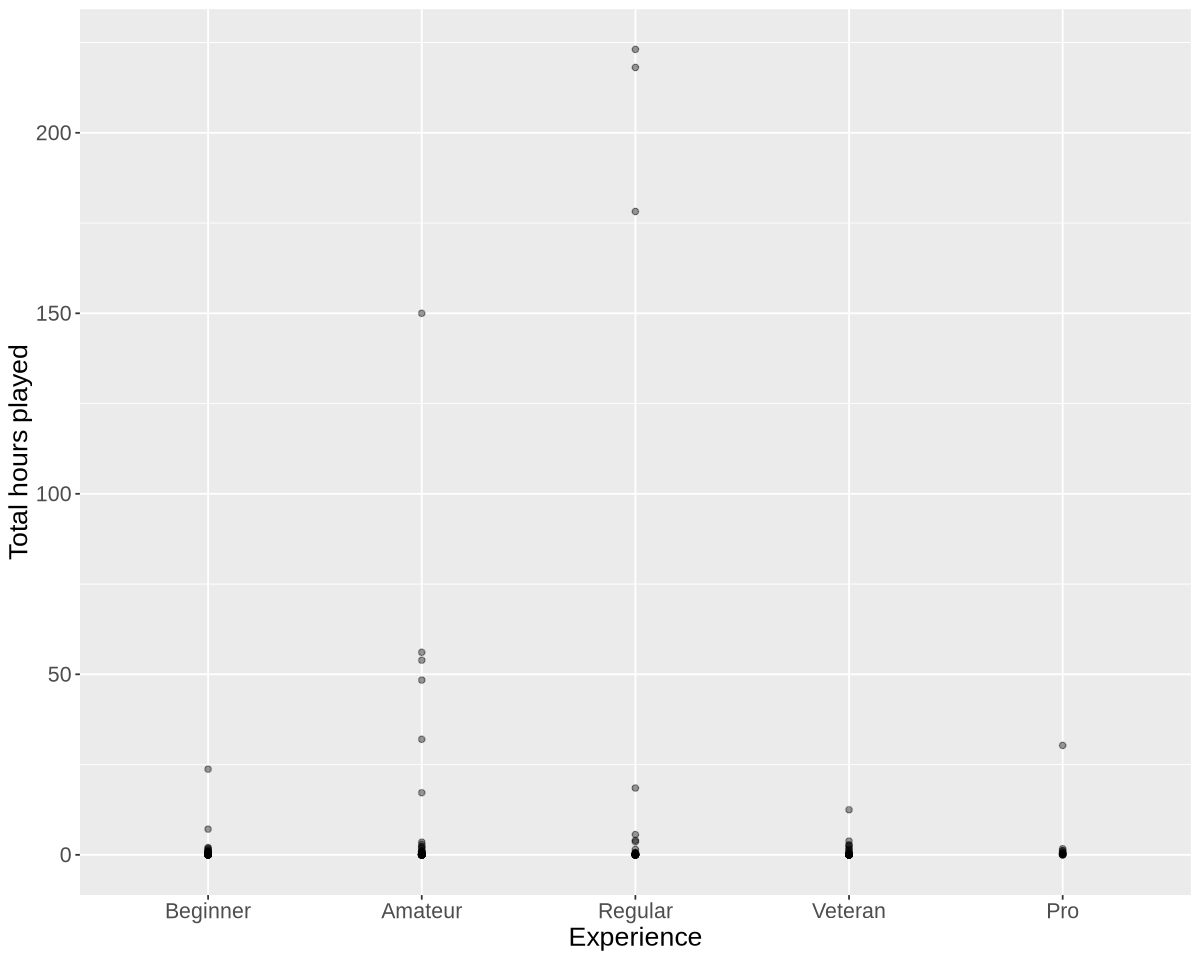

In [6]:
# Transform Experience INTO a factor - Generate factor variable for experience level -> Code taken from Jason's individual report
unique(cleaned_players$experience)
experience_levels <- c("Beginner", "Amateur", "Regular", "Veteran", "Pro")

transformed_players <- cleaned_players |>
    mutate(experience = factor(experience, levels = experience_levels), # factor variable           
          experience_num = case_when(experience == "Beginner" ~ 1,      # numeric variable for use in 
                                     experience == "Amateur" ~ 2,       #  regression in final report
                                     experience == "Regular" ~ 3,
                                     experience == "Veteran" ~ 4,
                                     experience == "Pro" ~ 5))

sample_transformed <- transformed_players |>
head()
sample_transformed

options(repr.plot.width = 10, repr.plot.height = 8)
players_expnum_plot <- ggplot(transformed_players, aes(x = experience, y = played_hours)) +
        geom_point(alpha = 0.4) +
        labs(x = "Experience", y = "Total hours played") +
        theme(text = element_text(size=16),
             plot.title = element_text(size=18))
players_expnum_plot
#Confirmation of Regular players still playing the most outside of all Experience Levels

**Figure 3: Total Hours Played vs Experience**

From preliminary investigations, it was noted that experience and age may have the most profound impacts on total playtime. For inclusion in our predictive model, we transformed experience to a numerical variable (i.e., 1 - “Beginner”, 2 - “Amateur”, etc.). From **Figure 3**, we explored the distribution of playtime according to experience, reaffirming our barplot findings.  

## Predictive Model and Analysis

### Overview of the approach

In this section, we perform a K-NN regression as it works well with non-linear relationships as observed between age and played hours, and experience and played hours. We split the data and tune our model on the training set using cross-validation. As part of the model tuning process, we use forward selection by first training a model using age as the only predictor, and then training a multivariable model using both age and experience level as predictors. After determining a model with optimal K and selection of predictors, we evaluate our predictive model on the testing set.

In [7]:
# Select variables of interest, remove age outliers
players_final <- transformed_players |>
select(played_hours, age, experience_num) |>
    filter(age <= 90)

head(players_final)

played_hours,age,experience_num
<dbl>,<dbl>,<dbl>
30.3,9,5
3.8,17,4
0.0,17,4
0.7,21,2
0.1,21,3
0.0,17,2


### Splitting the data

First, we split the players data into training and testing sets using a 70/30 split.

In [8]:
#### K-NN Regression ####

## Model 1: Predicting played hours based on age ##

# set seed
set.seed(237)

# set plot dimensions
options(repr.plot.width = 7, repr.plot.height = 7)

# split the data: 70 training / 30 testing
players_split <- initial_split(players_final, prop = 0.70, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

### Cross-validation

We perform a cross-validation to choose an optimal number of neighbours K. First, we create the model specification for tuning our K-NN regression model. Next, we construct the model recipe using played hours as the response variable and age as the predictor variable, with scaled and centered age. We construct a workflow using the recipe and model specification.

In [9]:
# Create model specification
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# Recipe
players_recipe <- recipe(played_hours ~ age, data = players_final) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Construct workflow
players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We consider the size of the training set when choosing the number of cross-validation folds. Given the relatively small size of the data, we take a conservative approach and choose 5 folds. We use the argument *strata = played_hours* to ensure even distributions of the response variable across the 5 folds. We compute the root mean square prediction error (RMSPE) for values of K from 1 to 9, and plot the RMSPE for each value of K.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,40.86266,5,2.906464,Preprocessor1_Model1
2,rmse,standard,30.25588,5,5.693520,Preprocessor1_Model2
3,rmse,standard,26.09595,5,7.095070,Preprocessor1_Model3
4,rmse,standard,24.81597,5,7.611349,Preprocessor1_Model4
5,rmse,standard,23.80602,5,7.992005,Preprocessor1_Model5
6,rmse,standard,24.40707,5,7.759840,Preprocessor1_Model6
7,rmse,standard,24.71219,5,7.552085,Preprocessor1_Model7
8,rmse,standard,23.78544,5,8.017065,Preprocessor1_Model8
9,rmse,standard,23.81999,5,7.990151,Preprocessor1_Model9


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,rmse,standard,23.78544,5,8.017065,Preprocessor1_Model8


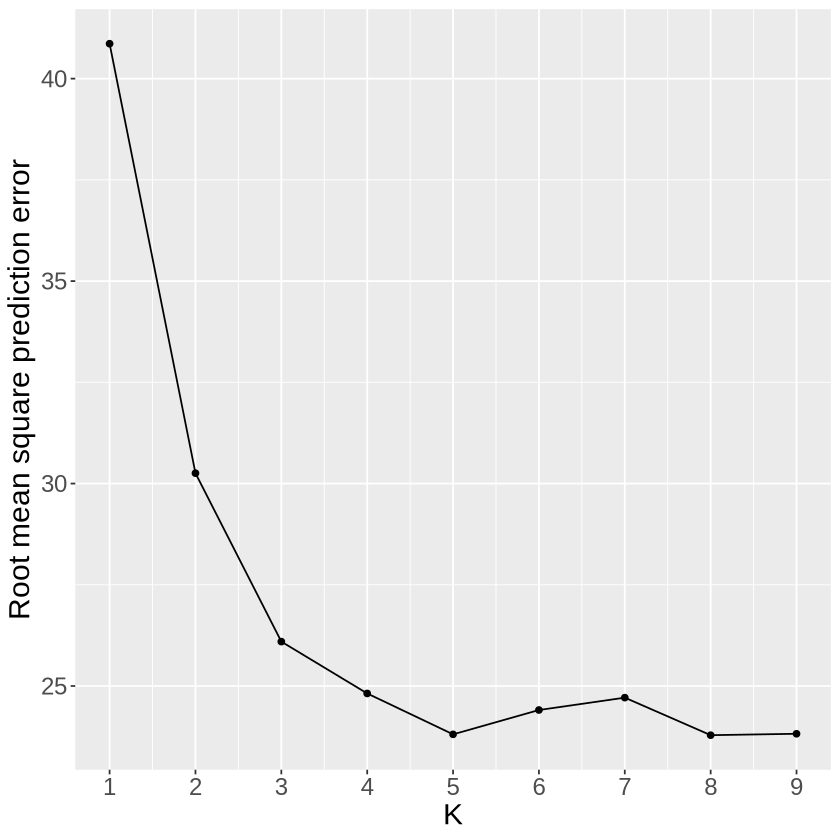

In [10]:
# Specify number of cross-validation folds
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

# Specify number of neighbors to compare
gridvals <- tibble(neighbors = seq(from = 1, to = 9, by = 1))

# Compute RMSPE for different values of K neighbors
players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

players_results

rmspe <- players_results |>
    # filter(.metric == "rmse") |>
    select(neighbors, mean)

# Plot RMSPE vs K
rmspe_plot <- rmspe |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K", 
         y = "Root mean square prediction error",
        # title = "Figure 4: Relationship between root mean square prediction error and number of neighbors K"
        ) +
    theme(text = element_text(size = 18)) +
    scale_x_continuous(breaks = seq(1,9, by = 1), limits = c(1,9)) 

rmspe_plot

# Extract minimum RMSPE
players_min <- players_results |>
    filter(.metric == "rmse") |>
    slice_min(order_by = mean, n = 1)

players_min

**Figure 4. Relationship between root mean square prediction error and number of neighbors K.**

We obtained a minimum RMSPE value of 23.8 hours corresponding to K = 8 (**Figure 4**). We select K = 8 as the optimal K found by cross-validation and store it as the object *k_min*.

In [11]:
# Create object for optimal K
k_min <- players_min |>
    pull(neighbors)
k_min

[1] 8

### Forward selection: adding experience level to the model

We investigate whether adding experience as a predictor improves our model (i.e., lowers the RMSPE estimated by cross-validation). We create a new recipe for a multivariable model with both age and experience as predictors, and repeat the tuning process using cross-validation.

In [12]:
## Model 2: Predicting played hours based on age and experience level ##

# Create model specification
# players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#     set_engine("kknn") |>
#     set_mode("regression")

# Recipe
players_recipe_1 <- recipe(played_hours ~ age + experience_num, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Construct workflow
players_workflow_1 <- workflow() |>
    add_recipe(players_recipe_1) |>
    add_model(players_spec)

players_workflow_1

# Specify number of cross-validation folds
# players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

# Compute RMSPE for different values of K neighbors
# gridvals <- tibble(neighbors = seq(from = 1, to = 9, by = 1))

players_results_1 <- players_workflow_1 |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

rmspe_1 <- players_results_1 |>
    # filter(.metric == "rmse") |>
    select(neighbors, mean)

# Find minimum RMSPE
players_min_1 <- players_results_1 |>
    filter(.metric == "rmse") |>
    slice_min(order_by = mean, n = 1)

players_min_1

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,rmse,standard,23.99193,5,6.782495,Preprocessor1_Model3


Compared to the first model with age as the only predictor, the inclusion of experience level as a predictor results in a higher minimum RMSPE of 24.0 hours. In other words, including experience level as an additional predictor does not improve our model. Therefore, we proceed with the first model using age as the only predictor.

### Evaluating the model on the testing set

We create a new K-NN regression model specification using the optimal K that we found in our first model. We create a new workflow using our new model specification and fit a model on the entire training set. We then evaluate our final tuned model on the testing set and output the RMSPE of our predictions on the testing set. The predictions are plotted over the original data (**Figure 5**).

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,31.443451640
rsq,standard,0.006523515
mae,standard,8.082083333


.pred,played_hours,age,experience_num
<dbl>,<dbl>,<dbl>,<dbl>
0.0250,0.0,17,4
0.0250,0.0,17,2
0.1125,0.0,21,2
0.0250,0.1,17,2
0.1750,0.0,22,4
0.1750,0.0,22,2


Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


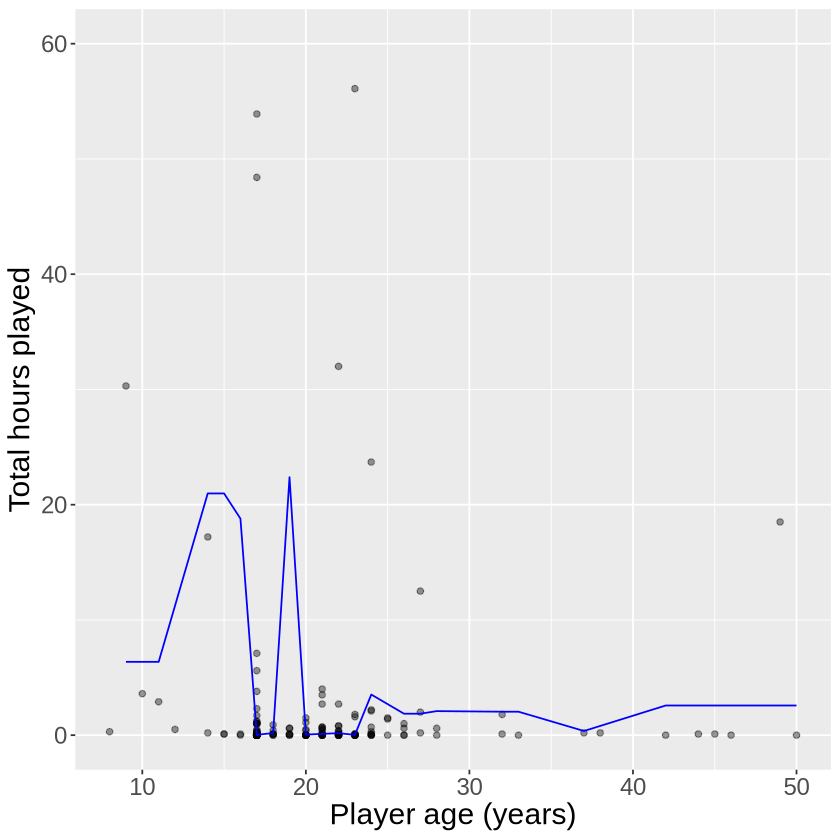

In [13]:
# Create model specification using optimal K
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")

# Create new workflow using best spec and fit on training set
players_best_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_best_spec) |>
    fit(data = players_training)

# Evaluate tuned model on the testing set
players_results <- players_best_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    metrics(truth = played_hours, estimate =.pred)

players_results

# Plot predictions over the original players data
players_preds <- players_best_fit |>
    predict(players_training) |>
    bind_cols(players_training)

head(players_preds)

players_plot <- ggplot(data = players_final, aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.4) +
    geom_line(data = players_preds, 
              mapping = aes(x = age, y = .pred),
              color = "blue") + 
    xlab("Player age (years)") +
    ylab("Total hours played") +
    # ylim(c(0,25)) +
    # ggtitle("Figure 5: Predictions using K = 8") +
    # ggtitle(paste0("Figure Y: Predictions using K = ", k_min)) +
    theme(text = element_text(size = 18))

#players_plot                 #full scale
players_plot + ylim(c(0,60))  #zoomed in

**Figure 5: Predictions by the final tuned model (K = 8).**

We obtained a testing RMSPE of 31.4 hours. This can be interpreted as: the predictions on the test data given by our model have an error of approximately +/- 31.4 hours on average. Whether an RMSPE value is “good” depends on the problem. In the context of our research question, a prediction error of around 31 hours is high, especially given that the majority of registered players contribute less than 1 hour of playing time (75th percentile = 0.6 played hours). Therefore, this model trained on the PLAIcraft data may not accurately predict playtime based on age.

In [14]:
quantile(cleaned_players$played_hours, seq(0,1,0.25))

0%   25%   50%   75%  100% 
  0.0   0.0   0.1   0.6 223.1

## Discussion

Our exploratory data analysis demonstrated that total playtime may be related to age and experience. We performed a K-NN regression to determine whether these variables might accurately predict total playtime. Forward selection revealed that the inclusion of experience as a predictor in our model did not improve performance. We arrived at a final tuned model that predicts total playtime based on age, with a testing RMSPE of 31.4 hours. Our model predicts the highest playtimes for future players in their pre-teen or teenage years. However, the predictions should be interpreted with caution, given the high prediction error. 

### Expectations of Findings

We expected that playtime predictions would be higher for younger players, as younger demographics may have more free time or have greater interest in PLAICraft. However, our expectations were guarded, given the self-reported nature of age and experience and potential for response bias (Palhus, 1991). We note that our predictions were likely influenced by observations with playtimes over 150 hours. These outliers may have had a large impact on our predictions especially given the small size of the training data. Similarly, the increase in predicted hours played by players aged 40-50 may seem surprising given the lack of data points for this age group (**Figure 5**). K-NN regression relies on nearby data points, so predictions for players aged 40-50 may have been skewed by the density of data points for younger age groups.


### Impact of Findings ###

Recruiters may want to focus on teenagers, as predicted playtimes are highest for this group. Our results showed lower predicted playtimes for players aged 30+ as expected, but unexpectedly also for players aged 17 to 18. The reasons for the inconsistency in playtimes for players aged 17 to 18 compared with other teenage groups is unclear. Additionally, we observed a dip in predicted hours between ages 20 and 23, which may reflect students having less time for gaming or graduating. Age alone may not be the best predictor of gameplay hours and recruiters might consider other factors.

Finally, it is also important to note the limitations of using K-NN regression. This model performs poorly when making predictions beyond the range of its training data or for subranges with a sparsity of observations (Timbers et al., 2024). From our exploratory analysis, it is clear that our sample did not contain an even distribution of age or experience. For example, **Figure 2** demonstrates that the majority of players are roughly 18 years old. Consequently, when asked to make a prediction about the total playtime for a 50 year-old player, we would expect our model’s accuracy to suffer. K-NN also becomes slower as training data gets larger due to the nature of the algorithm. Considering that PLAI’s goal is to grow their user base, there may be a point at which the data becomes large enough that K-NN regression becomes infeasible. Finally, the results of K-NN regression are less interpretable than a comparable model like linear regression, where the coefficients for the regression function imply the expected change in the response variable with a given change in a predictor variable.

### Future Inquiries ### 

PLAI might consider expanding the data fields collected in the future to better understand their player base. Additional information on individuals’ gaming habits, occupation, and reasons for participating may provide further insights on the play patterns currently observed. For example, we found that most registered players contributed less than 1 hour of gameplay, with many contributing zero hours, and the reasons for this remain unclear. Other underlying factors such as PLAI’s current recruitment strategy (e.g., convenience sampling of students) could also explain some of these low play patterns. Interestingly, 17-18 year olds showed lower predicted playtimes, possibly due to post-secondary education preparation or personal game preferences. For many pre-teens, this study might be their first exposure to Minecraft, encouraging consistent play. 

We recognize the results obtained from this dataset cannot be considered a true representation of the overall gaming population given the narrow participant pool (i.e., namely, university students). In future, extending the data collection period and broadening the participant pool may help improve predictions and, with larger sample sizes, open up the possibility of clustering methods that can be used to identify meaningful player subgroups for predictive modeling.

## References

1. Paulhus, D. L. (1991). Measurement and control of response bias. In Measures of personality and social psychological attitudes (pp. 17–59). Academic Press. https://doi.org/10.1016/B978-0-12-590241-0.50006-X
2. Timbers, T., Trevor, C., & Lee, M. (2024). Data Science. https://datasciencebook.ca/